In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import project3
from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
sns.set_theme()

# Problem 1

Calculate and compare the expected value and standard deviation of price at time t ($P_t$). Given each of the 3 types of price returns, assuming $r_t\sim N(0,\sigma^2)$. Simulate each return equation using $r_t\sim N(0,\sigma^2)$ and show the mean and standard deviation match your expectations.

In [2]:
class simulate_price:
    '''Simulate the Price at date t given condition of price at date t-1 or t-time_periods'''
    def __init__(self,init_p,path_num=2000,time_periods=1):
        # initial price
        self.__init_p=init_p
        # random number generator from numpy
        self.__rng=np.random.default_rng()
        # Assume we only know the price of time T-time_periods
        self.__time_periods=time_periods
        # How much path/times of Monte Carlo simulations we will do
        self.__path_num=path_num

    def ClassicalBrownianMotion(self,mu=0,std=1):
        '''P_t=P_{t-1}+r_t'''
        # random normal returns
        random_returns=self.__rng.normal(mu,std,size=[self.__time_periods,self.__path_num])
        zeros=np.zeros([1,self.__path_num]) # keep initial price
        random_returns=np.r_[zeros,random_returns]
        random_returns=pd.DataFrame(random_returns)
        # price sample
        Price=self.__init_p + random_returns.cumsum()
        return Price
        

    def ArithmeticReturn(self,mu=0,std=1):
        '''P_t=P_{t-1}*(1+r_t)'''
        # random normal returns
        random_returns=self.__rng.normal(mu,std,size=[self.__time_periods,self.__path_num])
        zeros=np.zeros([1,self.__path_num]) # keep initial price
        random_returns=np.r_[zeros,random_returns]
        random_returns=pd.DataFrame(random_returns)
        # price sample
        Price=self.__init_p * (1+random_returns).cumprod()
        return Price
    
    def LogReturn(self,mu=0,std=1):
        '''Geometric Brownian Motion:
            P_t=P_{t-1}e^{r_t}
        '''
        # random normal returns
        random_returns=self.__rng.normal(mu,std,size=[self.__time_periods,self.__path_num])
        zeros=np.zeros([1,self.__path_num]) # keep initial price
        random_returns=np.r_[zeros,random_returns]
        random_returns=pd.DataFrame(random_returns)
        # price sample
        Price=self.__init_p * np.exp(random_returns.cumsum())
        return Price

    def expected_mean_var(self,mu=0,std=1):
        '''Calculate the expected Mean and Variance()'''

        ans=pd.DataFrame(columns=['Classical Brownian Motion', 'Arithmetic Return', 'Log Return (Geometric Brownian Motion)'],index=['Expected Mean','Expected Standard Deviation'])
        t=self.__time_periods #  time_periods
        p=self.__init_p # initial price
        mu=t*mu # adjusted mu
        std=np.sqrt(t)*std # adjusted std
        var=std**2 
        mean_arith_rt=p*(1+mu) if t==1 else np.nan # mean of Arithmetic Return
        std_arith_rt=p*std if t==1 else np.nan # std of Arithmetic Return
        ans.loc['Expected Mean']=[p+mu,mean_arith_rt,p*np.exp(var/2)]
        ans.loc['Expected Standard Deviation']=[std,std_arith_rt,p*np.sqrt(np.exp(var)*(np.exp(var)-1))]
        return ans
    
    def comparison(self,mu=0,std=1):
        Price=pd.DataFrame(columns=['Classical Brownian Motion', 'Arithmetic Return', 'Log Return (Geometric Brownian Motion)'])
        
        # Get all the price
        Classical_BM=self.ClassicalBrownianMotion(mu=mu,std=std)
        Arithmetic_r=self.ArithmeticReturn(mu=mu,std=std)
        Log_r=self.LogReturn(mu=mu,std=std)
        
        # Get end date price
        Price.iloc[:,0]=Classical_BM.iloc[-1,:]
        Price.iloc[:,1]=Arithmetic_r.iloc[-1,:]
        Price.iloc[:,2]=Log_r.iloc[-1,:]
        
        # Calculate expected Mean & Variance
        expected=self.expected_mean_var(mu,std)

        # Mean & Standard Deviation
        df=pd.DataFrame(columns=['Classical Brownian Motion', 'Arithmetic Return', 'Log Return (Geometric Brownian Motion)'],index=['Mean','Expected Mean','Standard Deviation','Expected Standard Deviation'])
        df.loc['Mean']=Price.mean()
        df.loc['Standard Deviation']=Price.std()
        df.loc['Expected Mean']=expected.loc['Expected Mean']
        df.loc['Expected Standard Deviation']=expected.loc['Expected Standard Deviation']
        print(df)

        # Plot
        fig, ax = plt.subplots(3,2,figsize=(14,20))
        Classical_BM.plot(ax=ax[0][0],legend=False,xlabel='Time',ylabel='Price',title="Classical Brownian Motion({} path)".format(self.__path_num))
        Arithmetic_r.plot(ax=ax[1][0],legend=False,xlabel='Time',ylabel='Price',title="Arithmetic Return({} path)".format(self.__path_num))
        Log_r.plot(ax=ax[2][0],legend=False,xlabel='Time',ylabel='Price',title="Log Return (Geometric Brownian Motion)({} path)".format(self.__path_num))

        sns.histplot(data=Price['Classical Brownian Motion'],kde=True,stat="density",ax=ax[0][1])
        sns.histplot(data=Price['Arithmetic Return'],stat="density",kde=True,ax=ax[1][1])
        sns.histplot(data=Price['Log Return (Geometric Brownian Motion)'],stat="density",kde=True,ax=ax[2][1])
        ax[0][1].set_title("End Date Price Distribution")
        ax[1][1].set_title("End Date Price Distribution")
        ax[2][1].set_title("End Date Price Distribution")

        # Save file
        writer = pd.ExcelWriter('Validation.xlsx')  #Build excel file
        # Use float_format to control precision; write data_df to the last page of file. If we have mutiple file, we could write sequentially.
        df.to_excel(writer,'page_1',float_format='%.5f') 
        writer.save()  # save file


                            Classical Brownian Motion Arithmetic Return  \
Mean                                         0.994999          1.020364   
Expected Mean                                       1                 1   
Standard Deviation                           0.511219          0.508505   
Expected Standard Deviation                       0.5               0.5   

                            Log Return (Geometric Brownian Motion)  
Mean                                                      1.105693  
Expected Mean                                             1.133148  
Standard Deviation                                         0.58632  
Expected Standard Deviation                               0.603901  


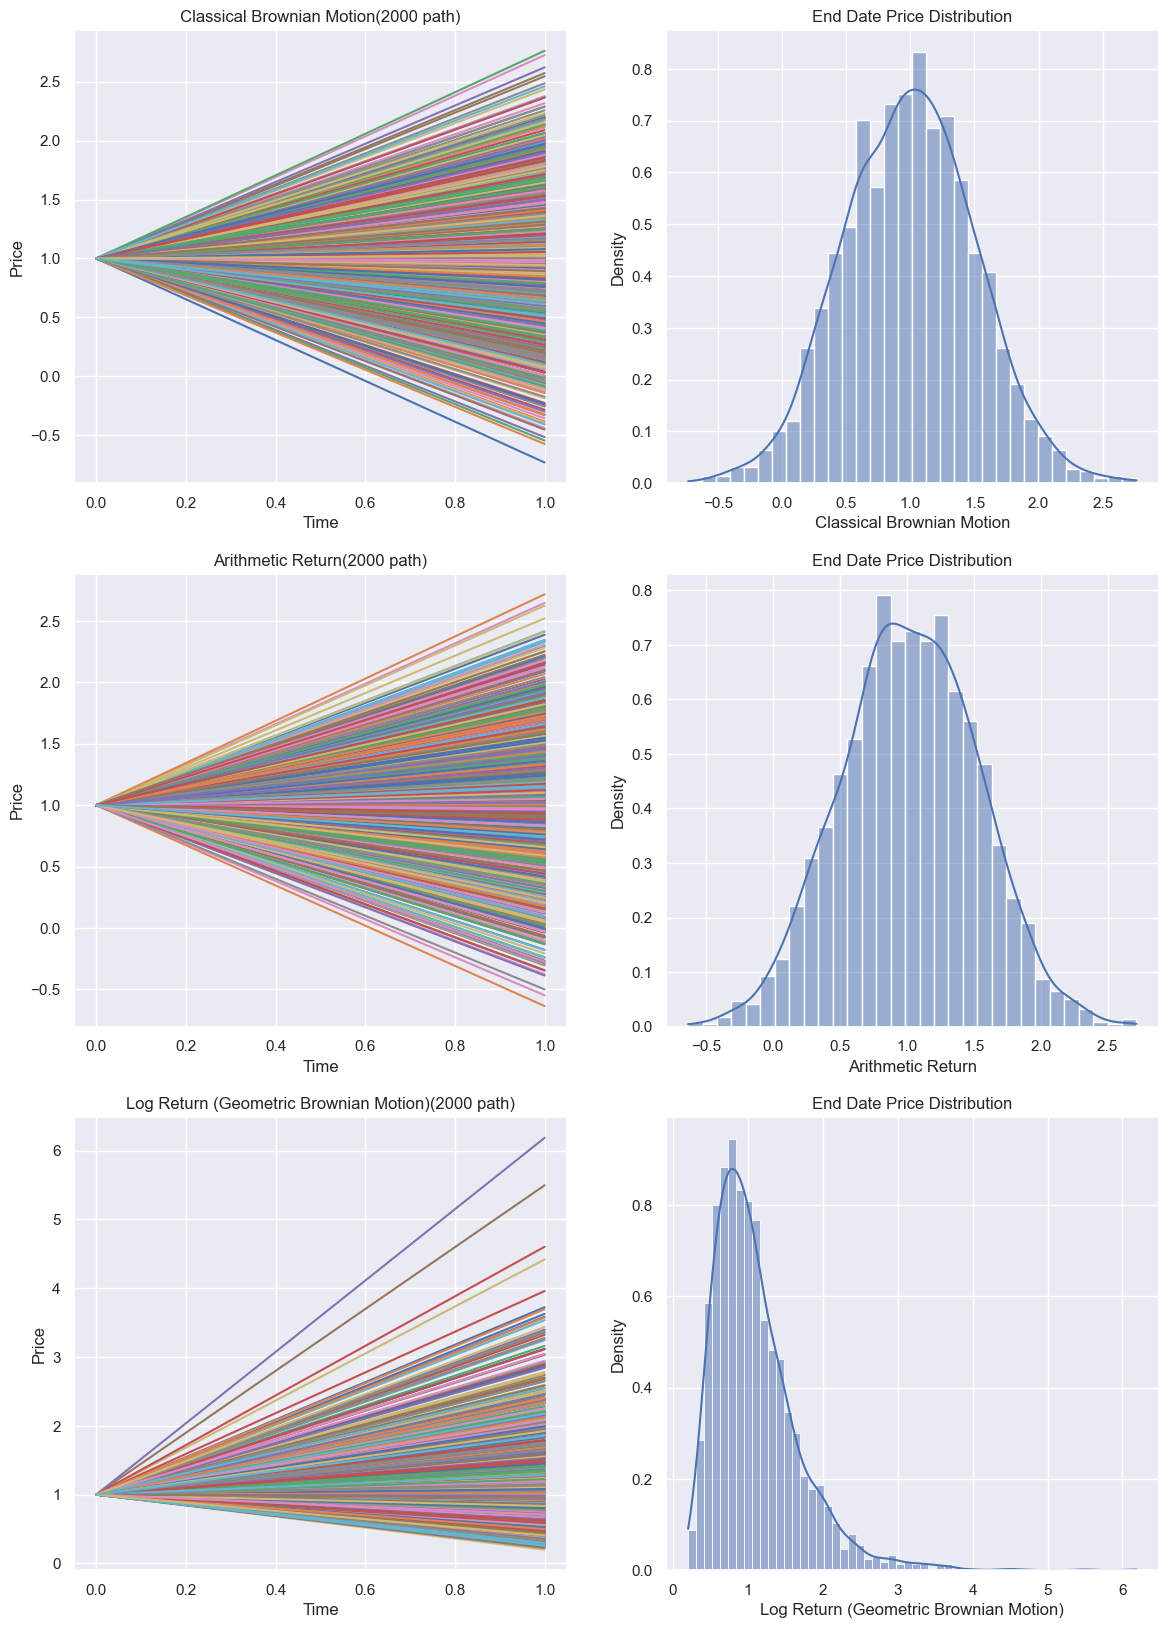

In [3]:
simulate_price(1,path_num=2000,time_periods=1).comparison(std=0.5)

                            Classical Brownian Motion Arithmetic Return  \
Mean                                         0.993898          0.999384   
Expected Mean                                       1               NaN   
Standard Deviation                           0.495563          0.542219   
Expected Standard Deviation                       0.5               NaN   

                            Log Return (Geometric Brownian Motion)  
Mean                                                      1.124526  
Expected Mean                                             1.133148  
Standard Deviation                                        0.572693  
Expected Standard Deviation                               0.603901  


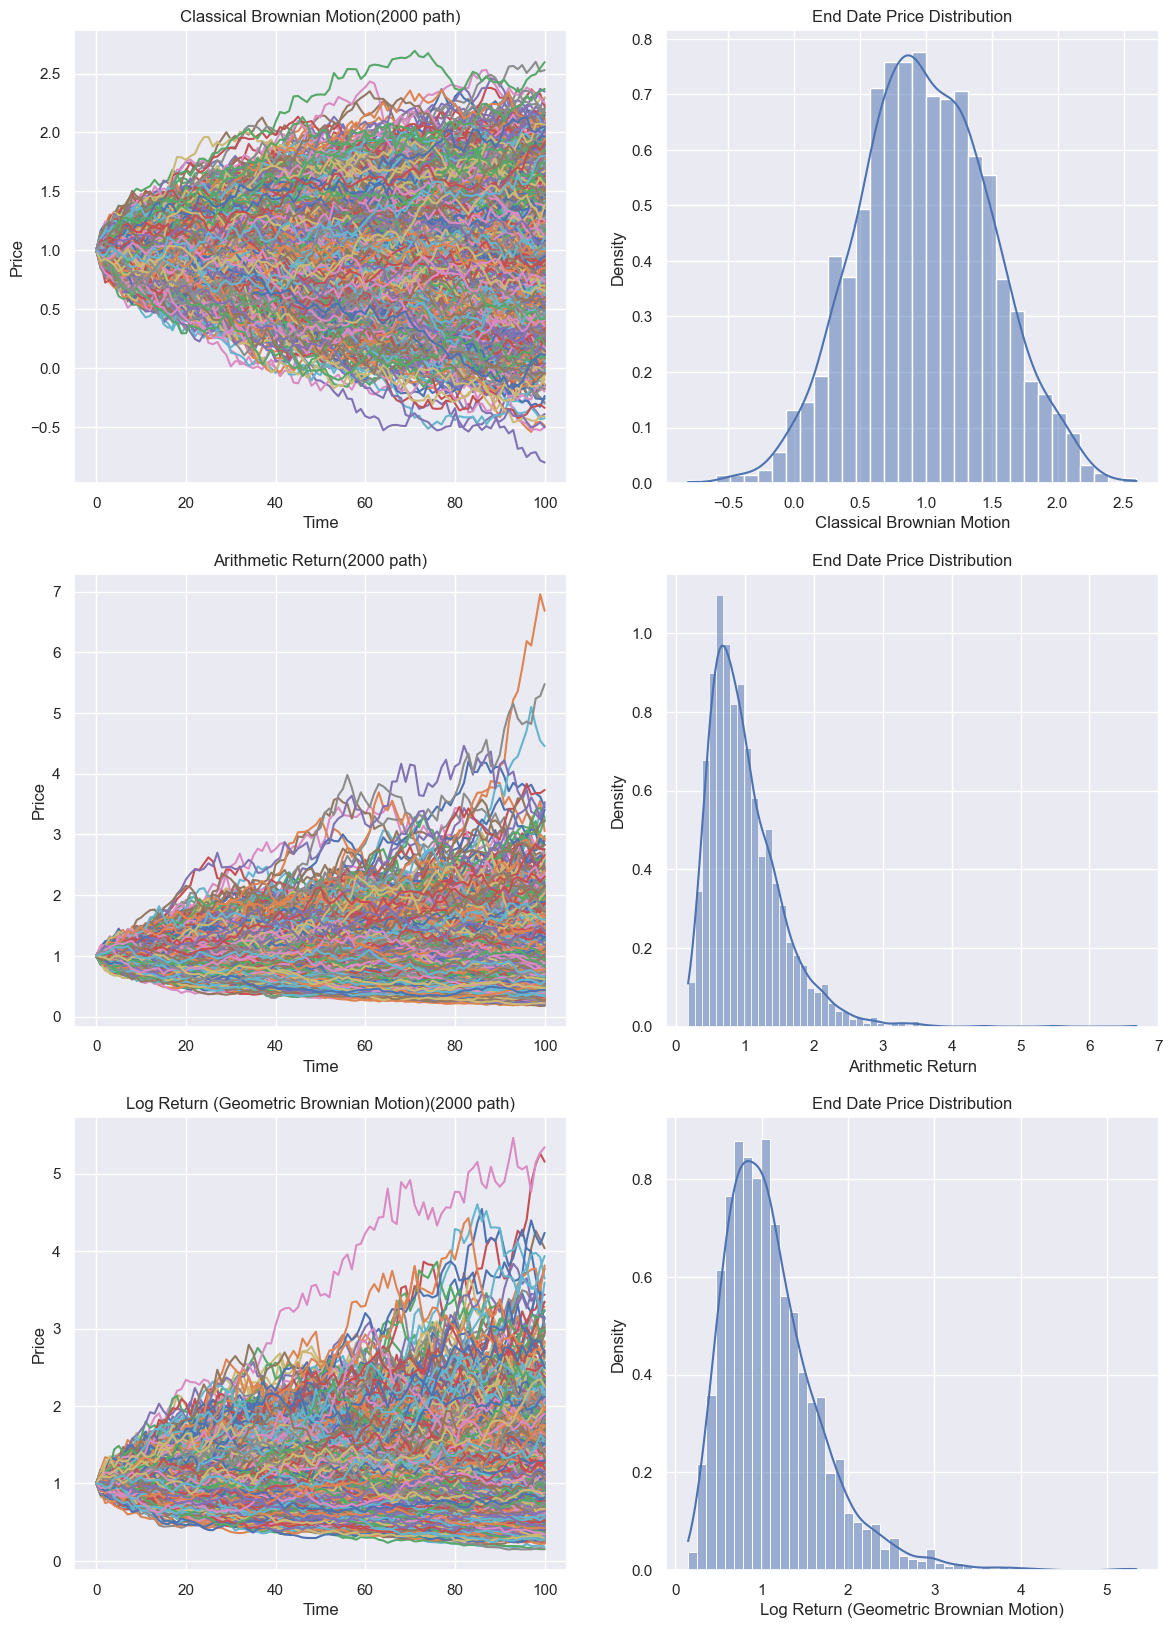

In [4]:
simulate_price(1,path_num=2000,time_periods=100).comparison(std=0.05)

# Problem 2

Implement a function similar to the “return_calculate()” in this week’s code. Allow the user to specify the method of return calculation.

Use DailyPrices.csv. Calculate the arithmetic returns for all prices.

Remove the mean from the series so that the mean(META)=0.

Calculate VaR:
1. Using a normal distribution.
2. Using a normal distribution with an Exponentially Weighted variance $\lambda$ = 0. 94
3. Using a MLE fitted T distribution.
4. Using a fitted AR(1) model.
5. Using a Historic Simulation.

Compare the 5 values.

In [90]:
def return_calculate(Price,option="DISCRETE",rm_means=True):
    '''
        Provide two ways to calculate the return from Price dataframce.
    '''
    # calculate the log normal return 
    if option == 'CONTINUOUS':
        returns = np.log(df/df.shift()).dropna()
    # calculate the discrete return 
    elif  option == 'DISCRETE':
        returns = df.pct_change().dropna()
    # other undefined option will cause error
    else:
        raise Exception("Unknown Option!")
    # remove mean from the returns
    return returns if rm_means==False else returns-returns.mean()
    

In [91]:
class T_fitter:
    '''T distribution MEL fitter'''
    def ll_t(self,parameter,x):
        # log likelihood 
        ll=np.sum(stats.t.logpdf(x=x,df=parameter[0],loc=0,scale=parameter[1])) # assume mean to be 0
        return -ll

    def MLE(self,x):
        cons=[ {'type':'ineq', 'fun':lambda x:x[1]} ] # standard deviation is non-negative
        parameter = np.array([x.size-1,1])
        MLE = minimize(self.ll_t, parameter, args = x, constraints = cons) # MLE
        return MLE.x

In [92]:
def simulate_AR1_process(alpha,beta,sigma,sample_size):
    # Simulate AR(1) process
    ''' AR(1)
        y_t = alpha + beta*y_t-1 + e, e ~ N(0,sigma2)
    '''
    x0=alpha/(1-beta)
    x=np.zeros(sample_size+1)
    x[0]=x0
    eps=stats.norm.rvs(size=sample_size,scale=sigma)
    for i in range(sample_size):
        x[i+1]=alpha+beta*x[i]+eps[i]
    return x

In [93]:
class VaR:
    '''Calculate the VaR of 1D array or dataframe of return due to specific distribution'''
    def __init__(self,data,option="Absolute",alpha=0.05):
        # Absolute Value at risk or Relative Value at risk
        if option != "Absolute" and option != "Relative":
            raise Exception('Unknown option!')
        self.__option=option
        # 1-alpha is confidence level
        self.__alpha=alpha
        # returns data
        self.__data=data

    def normal(self,option='Normal',plot=False):
        '''Assume returns follow normal distribution'''
        # assume mean to be 0
        mu=0
        # calculate the standard deviation
        if option == 'Normal': # use normal standard deviation
            std=self.__data.std() 
        elif option == 'EWMA': # use EW standard deviation
            model=project3.EWMA(META,0.94) # assume lambda = 0.94
            std=np.sqrt(model.cov_mat)
        else: 
            raise Exception('Unknown option!')
         # calculate the VaR
        if self.__option=="Absolute":
            VaR=-stats.norm.ppf(self.__alpha,loc=mu,scale=std)
        else:
            VaR=self.__data.mean()-stats.norm.ppf(self.__alpha,loc=mu,scale=std)

        if plot:
            # plot the normal Probability density function
            max_val=self.__data.max()
            min_val=self.__data.min()
            x=np.linspace(min_val,max_val,1000)
            y=stats.norm.pdf(x=x,loc=mu,scale=std)
            plt.plot(x,y,color='brown')
            # plot the return data & its empirical kde
            sns.histplot(self.__data,kde=True,stat='density')
            # plot the VaR
            plt.axvline(-VaR,color='#FF6347')
            if option == 'Normal':
                plt.title("Normal")
                plt.legend(['Normal','historical','VaR'])
            else:
                plt.title("Normal with EW standard deviation")
                plt.legend(['Normal','historical','VaR'])
        return VaR
        
    def T_dist(self,plot=False):
        para=T_fitter().MLE(self.__data)
        mu=0 # assume mean to be 0
        df=para[0] # degree of freedom of T distribution
        std=para[1] # standard deviation
        # calculate the VaR
        if self.__option=="Absolute":
            VaR=-stats.t.ppf(self.__alpha,df=df,loc=mu,scale=std)
        else:
            VaR=self.__data.mean()-stats.t.ppf(self.__alpha,df=df,loc=mu,scale=std)
        if plot:
            # plot the T Probability density function
            max_val=self.__data.max()
            min_val=self.__data.min()
            x=np.linspace(min_val,max_val,1000)
            y=stats.t.pdf(x=x,df=df,loc=mu,scale=std)
            plt.plot(x,y,color='brown')
            # plot the return data & its empirical kde
            sns.histplot(self.__data,kde=True,stat='density')
            # plot the VaR
            plt.axvline(-VaR,color='#FF6347')
            plt.title("MLE fitted T distribution")
            plt.legend(['T distribution','historical','VaR'])
        return VaR

    def AR_1(self,plot=False):
        # Use AR(1) fitter to find the best cofficience
        mod = sm.tsa.arima.ARIMA(META.values, order=(1, 0, 0))
        res = mod.fit()
        const=0 # constant number
        ar_L1=res.params[1] # cofficience of Lag 1
        sigma2=res.params[2] # variance of error term

        # AR(1) is also normal
        mu=0
        std=np.sqrt(sigma2/(1-ar_L1))

        # calculate the VaR
        if self.__option=="Absolute":
            VaR=-stats.norm.ppf(self.__alpha,loc=mu,scale=std)
        else:
            VaR=self.__data.mean()-stats.norm.ppf(self.__alpha,loc=mu,scale=std)
        
        if plot:
            # plot the AR(1) Probability density function
            max_val=self.__data.max()
            min_val=self.__data.min()
            x=np.linspace(min_val,max_val,1000)
            y=stats.norm.pdf(x=x,loc=mu,scale=std)
            plt.plot(x,y,color='brown')
            # plot the return data & its empirical kde
            sns.histplot(self.__data,kde=True,stat='density')
            # plot the VaR
            plt.axvline(-VaR,color='#FF6347')
            plt.title("fitted AR(1)")
            plt.legend(['fitted AR(1)','historical','VaR'])
        return VaR
    
    def historical_simulation(self,alpha,plot=False):
        size=self.__data.shape[0]
        rt=np.random.choice(self.__data,size=size)
        rt.sort()
        # calculate the VaR
        if self.__option=="Absolute":
            VaR=-np.quantile(rt,alpha)
        else:
            VaR=rt.mean()-np.quantile(rt,alpha)
        if plot:
            # plot the historical kde
            sns.kdeplot(rt,color='brown')
            # plot the return data & its empirical kde
            sns.histplot(self.__data,kde=True,stat='density')
            # plot the VaR
            plt.axvline(-VaR,color='#FF6347')
            plt.title("historical simulation")
            plt.legend(['historical simulation','historical','VaR'])
        return VaR
        

In [94]:
# parse the DailyPrices data into dataframe
df=pd.read_csv('DailyPrices.csv',index_col='Date')
# calculate the returns
rt=return_calculate(df)
META=rt['META']

0.06560156967533284

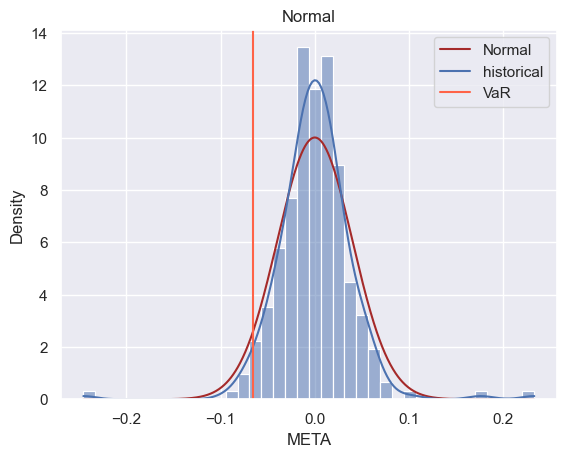

In [95]:
VaR(META).normal(plot=True)

0.09138525104032248

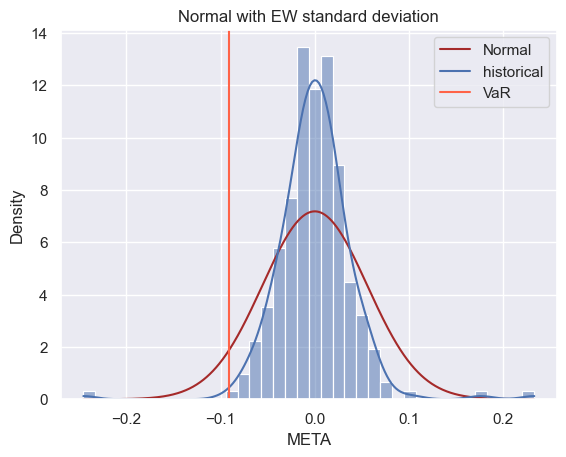

In [11]:
VaR(META).normal('EWMA',plot=True)

/Users/qijunyang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2126: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


0.05725632756853766

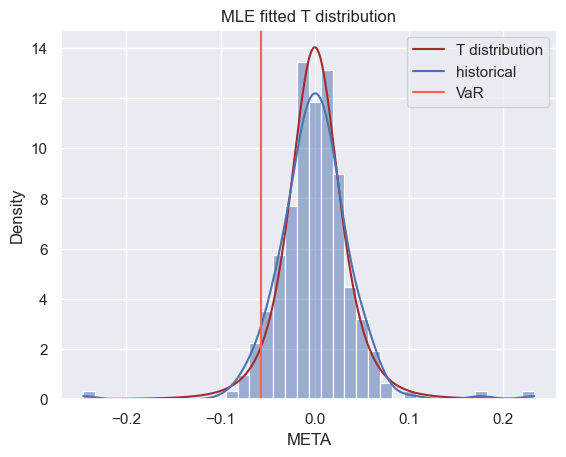

In [12]:
VaR(META).T_dist(plot=True)

0.06570519171558095

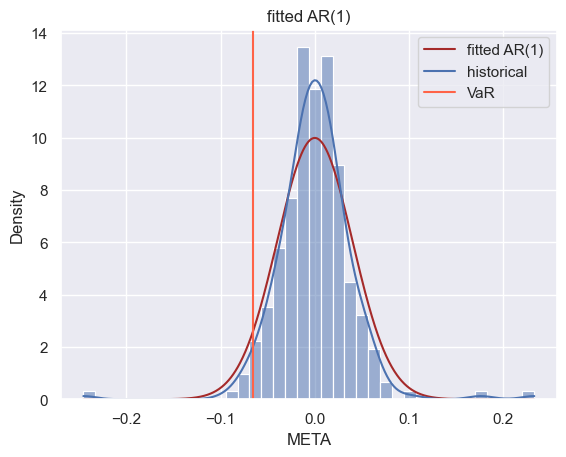

In [13]:
VaR(META).AR_1(plot=True)

0.06388181851304632

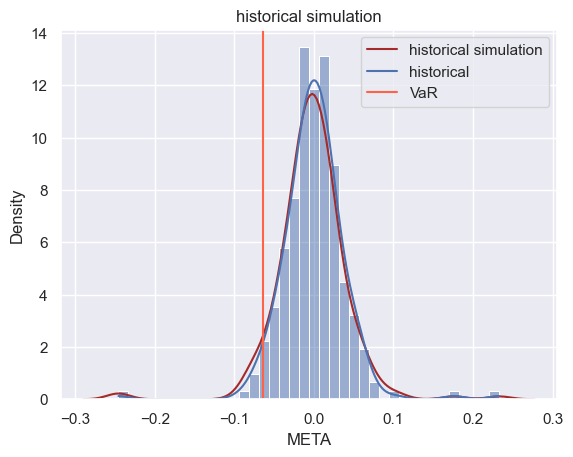

In [14]:
VaR(META).historical_simulation(0.05,plot=True)

# Problem 3

Using Portfolio.csv and DailyPrices.csv. Assume the expected return on all stocks is 0.

This file contains the stock holdings of 3 portfolios. You own each of these portfolios. Using an
exponentially weighted covariance with lambda = 0.94, calculate the VaR of each portfolio as
well as your total VaR (VaR of the total holdings). Express VaR as a $

Discuss your methods and your results.

Choose a different model for returns and calculate VaR again. Why did you choose that model? How did the model change affect the results?

In [16]:
# parse the DailyPrices data into dataframe
price=pd.read_csv('DailyPrices.csv',index_col='Date')
# calculate the returns
rt=return_calculate(price)
# information about portfolio
portfolio=pd.read_csv('portfolio.csv',index_col='Portfolio')

In [82]:
class VaR_portfolio:
    def __init__(self,portfolio,returns,price):
        # information about portfolio
        self.__portfolio=portfolio
        # returns information about companies
        self.__returns=returns
        # price about stock
        self.__price=price
    
    def normal(self,option='Normal'):
        VaR_portfolio=0
        for i in range(self.__portfolio.shape[0]):
            stock=self.__portfolio.iloc[i,:].Stock
            holding=self.__portfolio.iloc[i,:].Holding
            price=self.__price[stock][-1]
            rt=self.__returns[stock]
            VaR_company=VaR(rt).normal(option=option)
            VaR_portfolio+=VaR_company*price*holding
        return VaR_portfolio

    def historical_simulation(self,alpha):
        VaR_portfolio=0
        for i in range(self.__portfolio.shape[0]):
            stock=self.__portfolio.iloc[i,:].Stock
            holding=self.__portfolio.iloc[i,:].Holding
            price=self.__price[stock][-1]
            rt=self.__returns[stock]
            VaR_company=VaR(rt).historical_simulation(alpha)
            VaR_portfolio+=VaR_company*price*holding
        return VaR_portfolio

    def delta_normal(self):
        PV=0
        n=self.__portfolio.shape[0]
        delta=np.empty(n)
        returns=pd.DataFrame()
        for i in range(n):
            stock=self.__portfolio.iloc[i,:].Stock
            holding=self.__portfolio.iloc[i,:].Holding
            price=self.__price[stock][-1]
            returns[stock]=self.__returns[stock]
            PV+=price*holding
        for i in range(self.__portfolio.shape[0]):
            stock=self.__portfolio.iloc[i,:].Stock
            holding=self.__portfolio.iloc[i,:].Holding
            price=self.__price[stock][-1]
            delta[i]=holding*price/PV
        print(delta.shape)

        model=project3.EWMA(np.array(returns),0.94) # assume lambda = 0.94
        cov_mat=model.cov_mat
        print(cov_mat.shape)
        R=delta @ cov_mat @ delta
        return PV*R


In [97]:
A=VaR_portfolio(portfolio.loc['A'],rt,price).normal(option='EWMA')
print("VaR of portfolio A is {}".format(A))
B=VaR_portfolio(portfolio.loc['B'],rt,price).normal(option='EWMA')
print("VaR of portfolio B is {}".format(B))
C=VaR_portfolio(portfolio.loc['C'],rt,price).normal(option='EWMA')
print("VaR of portfolio C is {}".format(C))
All=VaR_portfolio(portfolio,rt,price).normal(option='EWMA')
print("VaR of the whole portfolio is {}".format(All))

VaR of portfolio A is 27411.01144802699
VaR of portfolio B is 26902.501119524597
VaR of portfolio C is 24677.931859413125
VaR of the whole portfolio is 78991.4444269647


In [98]:
A=VaR_portfolio(portfolio.loc['A'],rt,price).historical_simulation(0.05)
print("VaR of portfolio A is {}".format(A))
B=VaR_portfolio(portfolio.loc['B'],rt,price).historical_simulation(0.05)
print("VaR of portfolio B is {}".format(B))
C=VaR_portfolio(portfolio.loc['C'],rt,price).historical_simulation(0.05)
print("VaR of portfolio C is {}".format(C))
All=VaR_portfolio(portfolio,rt,price).historical_simulation(0.05)
print("VaR of the whole portfolio is {}".format(All))

VaR of portfolio A is 10379.821767974867
VaR of portfolio B is 9303.817473443714
VaR of portfolio C is 8043.318776452332
VaR of the whole portfolio is 28193.741749387915
